# Customer Churn example
To illustrate all the steps part of building a model, we'll build a customer churn model out of a Telco customer dataset.
We'll look into the existing features available to us and will later build an XGBoost model to predict the "Churn" column which is the label/target of interest.

The dataset is public and can be found here:
https://github.com/IBM/telco-customer-churn-on-icp4d

# Jupyter Notebook quick intro

Code vs Markdown Cells (raw only used if you want to export notebook with NBConvert)</br>
Shift + Return to execute a cell</br>
Tab - auto-completion</br>
Jupyter vs JupyterLab vs Sagemaker Studio</br>
</br>
Escape + ??</br>
Escape	enter command mode</br>
Escape + d + d	delete selected cell</br>
Escape + y	change cell to code</br>
Escape + m	change cell to markdown</br>
Escape + r	change cell to raw</br>
Escape + 1	change cell to Heading 1</br>
Escape + n	change cell to heading n</br>
Escape + b	create cell below</br>
Escape + a	Insert cell above</br>

# Let's get started!

<img src='img/Screen Shot 2021-09-15 at 12.06.44 pm.png' width=1000 align='left'>

## Load the dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', 100)

In [4]:
data_df = pd.read_csv('./data/Telco-Customer-Churn-with-null-and-outliers.csv')

## Pandas
Most popular python data analysis tool/library. </br>
Main object to store/manipulate data = DataFrame (similar in some ways to Spark)

## Exploratory Data Analysis (EDA)

<img src='img/Screen Shot 2021-09-15 at 12.22.59 pm.png' width=800 align='left'>

### Getting the shape of the dataset
-> 7043 rows and 21 columns/features

In [4]:
data_df.shape

(7043, 21)

### Display the first 5 line of the dataset
similarly, to display the last 5 lines of the dataset you'd use data_df.tail(5)

In [5]:
data_df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### playing with the data

Select a column only. Note that the below return a pandas series which is a different type of object than a Dataframe.

In [6]:
#data_df['gender']
data_df['gender'].head(2)

0    Female
1      Male
Name: gender, dtype: object

Filter a column on a specific value

In [7]:
data_df[data_df.gender == 'Female'].head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Get a view of the column type and presence of null values
We can notice that Dtype are either int/float so numerical values or object, meaning they are considered as categorical value by pandas.</br>
We can also notice that the tenure column/feature has some null value.

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            6992 non-null   float64
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Notes: 
- for some reasons (a space character), the TotalCharges is not an object so we force/cast the type to fix this.</br>
- the coerce parameter will input a NaN when not able to cast the value into a numeric

In [9]:
data_df.TotalCharges = pd.to_numeric(data_df.TotalCharges, errors='coerce')

### For numeric columns, describe() gives you mean, standard deviation, min,max etc

In [10]:
data_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,6992.000000,7043.000000,7032.000000
mean,0.162147,32.356836,64.761692,2291.462607
std,0.368612,24.548507,30.090047,2299.341231
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1398.425000
75%,0.000000,55.000000,89.850000,3801.400000
max,1.000000,72.000000,118.750000,22000.000000


### Get the distribution for a specific categorical feature/column
Note: data_df.gender is equivalent to data_df['gender']

In [11]:
data_df.gender.value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

### Get the cardinality of those categorical features
Note: will be useful later when encoding those features into numerical representations

In [12]:
cardinality_pd_series = data_df.apply(pd.Series.nunique)
cardinality_pd_series

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64

</br>We notice that a few of those features have yes/no values (cardinality = 2) so we'll turn those into 0/1 values

In [13]:
list_of_cols_to_transform = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

In [14]:
for col in list_of_cols_to_transform:
    data_df[col] = data_df[col].apply(lambda x: 0 if str(x).lower() == 'no' else 1)
    data_df[col] = pd.to_numeric(data_df[col])

In [15]:
data_df['gender'] = data_df['gender'].apply(lambda x: 0 if str(x).lower() == 'male' else 1)
data_df['gender'] = pd.to_numeric(data_df['gender'])

# Your Turn! play and manipulate the data

### Now let's draw some graphs!! 
Notes:</br>
Matplotlib is the goto library to draw graph in jupyter notebooks. </br>
Seaborn is a wrapper around matplotlib simplifying its usage.</br>
The plot method on Series and DataFrame is just a simple wrapper around plt.plot </br>

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

### Simple bar chart

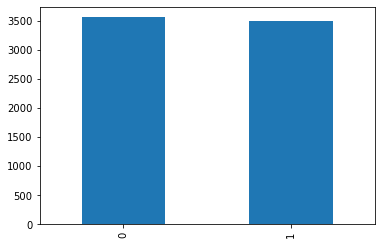

In [17]:
data_df.gender.value_counts().plot.bar()
plt.show()

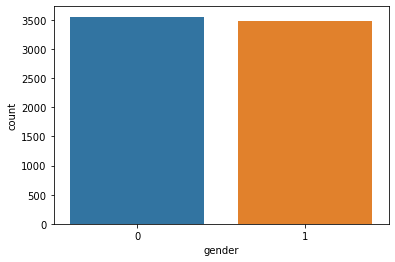

In [18]:
sns.countplot(x='gender', data=data_df)
plt.show()

### Looking at he distribution of the tenure
Histograms show distribution of numeric data. Data is divided into "buckets" or "bins".

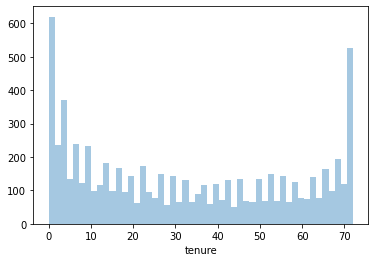

In [19]:
sns.distplot(data_df['tenure'], bins=50, kde=False)
# equivalent: data_df['tenure'].plot.hist(bins=30)
plt.show()

### Looking at the composition of certain features

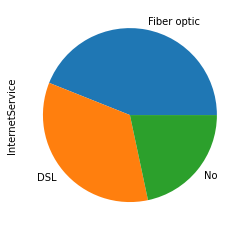

In [20]:
data_df['InternetService'].value_counts().plot.pie(y='InternetService')
plt.show()

### FacetGrid charts with seaborn
Note:</br>
- useful to identify differences across a combination of categorical features.</br> 
- be careful if you have high cardinality in those features, it will take a long time.</br>
- In that example, we can see that the month to month contracts have a higher Churn ratio, especially the contracts with no internet.

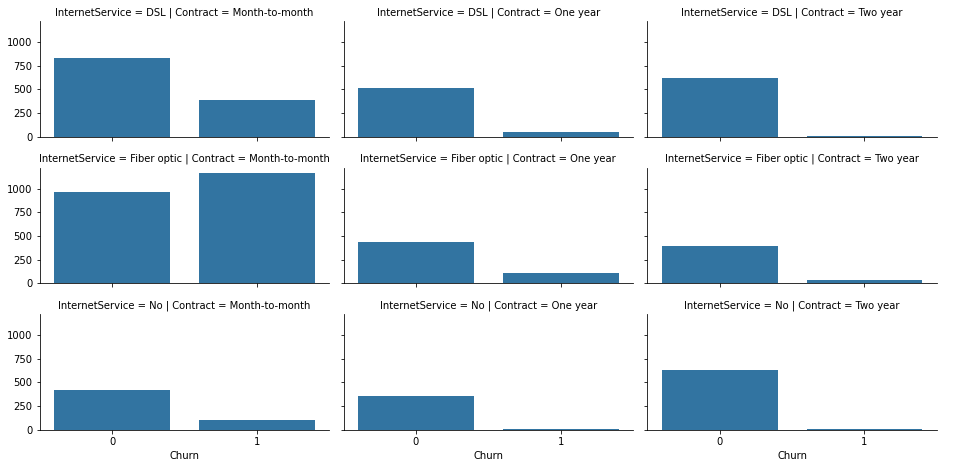

In [21]:
grid = sns.FacetGrid(data_df, col='Contract', row='InternetService', height=2.2, aspect=2)
grid.map(sns.countplot, 'Churn')
grid.add_legend();
plt.show()

### Looking at the relationship between 2 variables

#### Scatter plot
Shows how strongly pairs of features are related.
In that example, we show the obvious correlation between totalcharges and monthly charges as well as few outliers

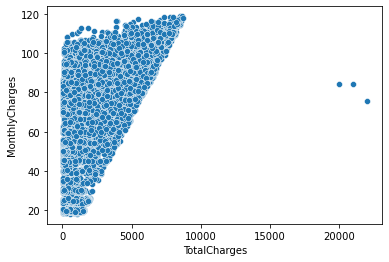

In [22]:
#plt.xticks(rotation=90)
sns.scatterplot(data=data_df.sample(frac=1), x='TotalCharges', y='MonthlyCharges')
plt.show()

<img src='img/Screen Shot 2021-09-15 at 5.48.53 pm.png' width=800 align='left'>

<img src='img/Screen Shot 2021-09-15 at 5.48.25 pm.png' width=800 align='left'>

### Let's generate a correlation matrix for our dataset

to generate a correlation matrix, we need numerical values so we need to transform our categorical features into numerical one.</br>
For that, we generate the one hot encoding representation of those categorical features.</br>

### Quick side explanation on categorical features encoding
we'll use that for the correlation matrix but especially just before training our model once we're done with the feature engineering.

<img src='img/Screen Shot 2021-09-17 at 11.20.26 am.png' width=800 align='left'>

<img src='img/Screen Shot 2021-09-17 at 11.20.38 am.png' width=800 align='left'>

In [23]:
def one_hot_encoding(df):
    #getting a list of categorical columns
    categorical_col = []
    for col in df.columns:
        col_dtype = df[col].dtype
        if col_dtype == 'object':
            categorical_col.append(col)

    #generating the one hot encoded features        
    df = pd.get_dummies(df, columns=categorical_col)
    print(df.shape)
    return df

In [24]:
#dropping the customerID as it is of no use for the correlation matrix
corr_data_df = one_hot_encoding(data_df.drop('customerID', axis=1))

(7043, 41)


We generate the correlation matrix

In [25]:
corrmat = corr_data_df.corr()

We identify the top 5 feature-label pairs with the highest correlation (=Pearson score), positive or negative (absolute value).

In [26]:
corrmat['Churn'].apply(lambda x: abs(x)).sort_values(ascending=False).drop('Churn').head(5)

Contract_Month-to-month        0.405103
tenure                         0.352447
OnlineSecurity_No              0.342637
TechSupport_No                 0.337281
InternetService_Fiber optic    0.308020
Name: Churn, dtype: float64

This tells us that those 5 features have the highest linear dependency (direct relationship) with the target amongst all features.

We generate a heatmap to visualise the pairs correlation. 

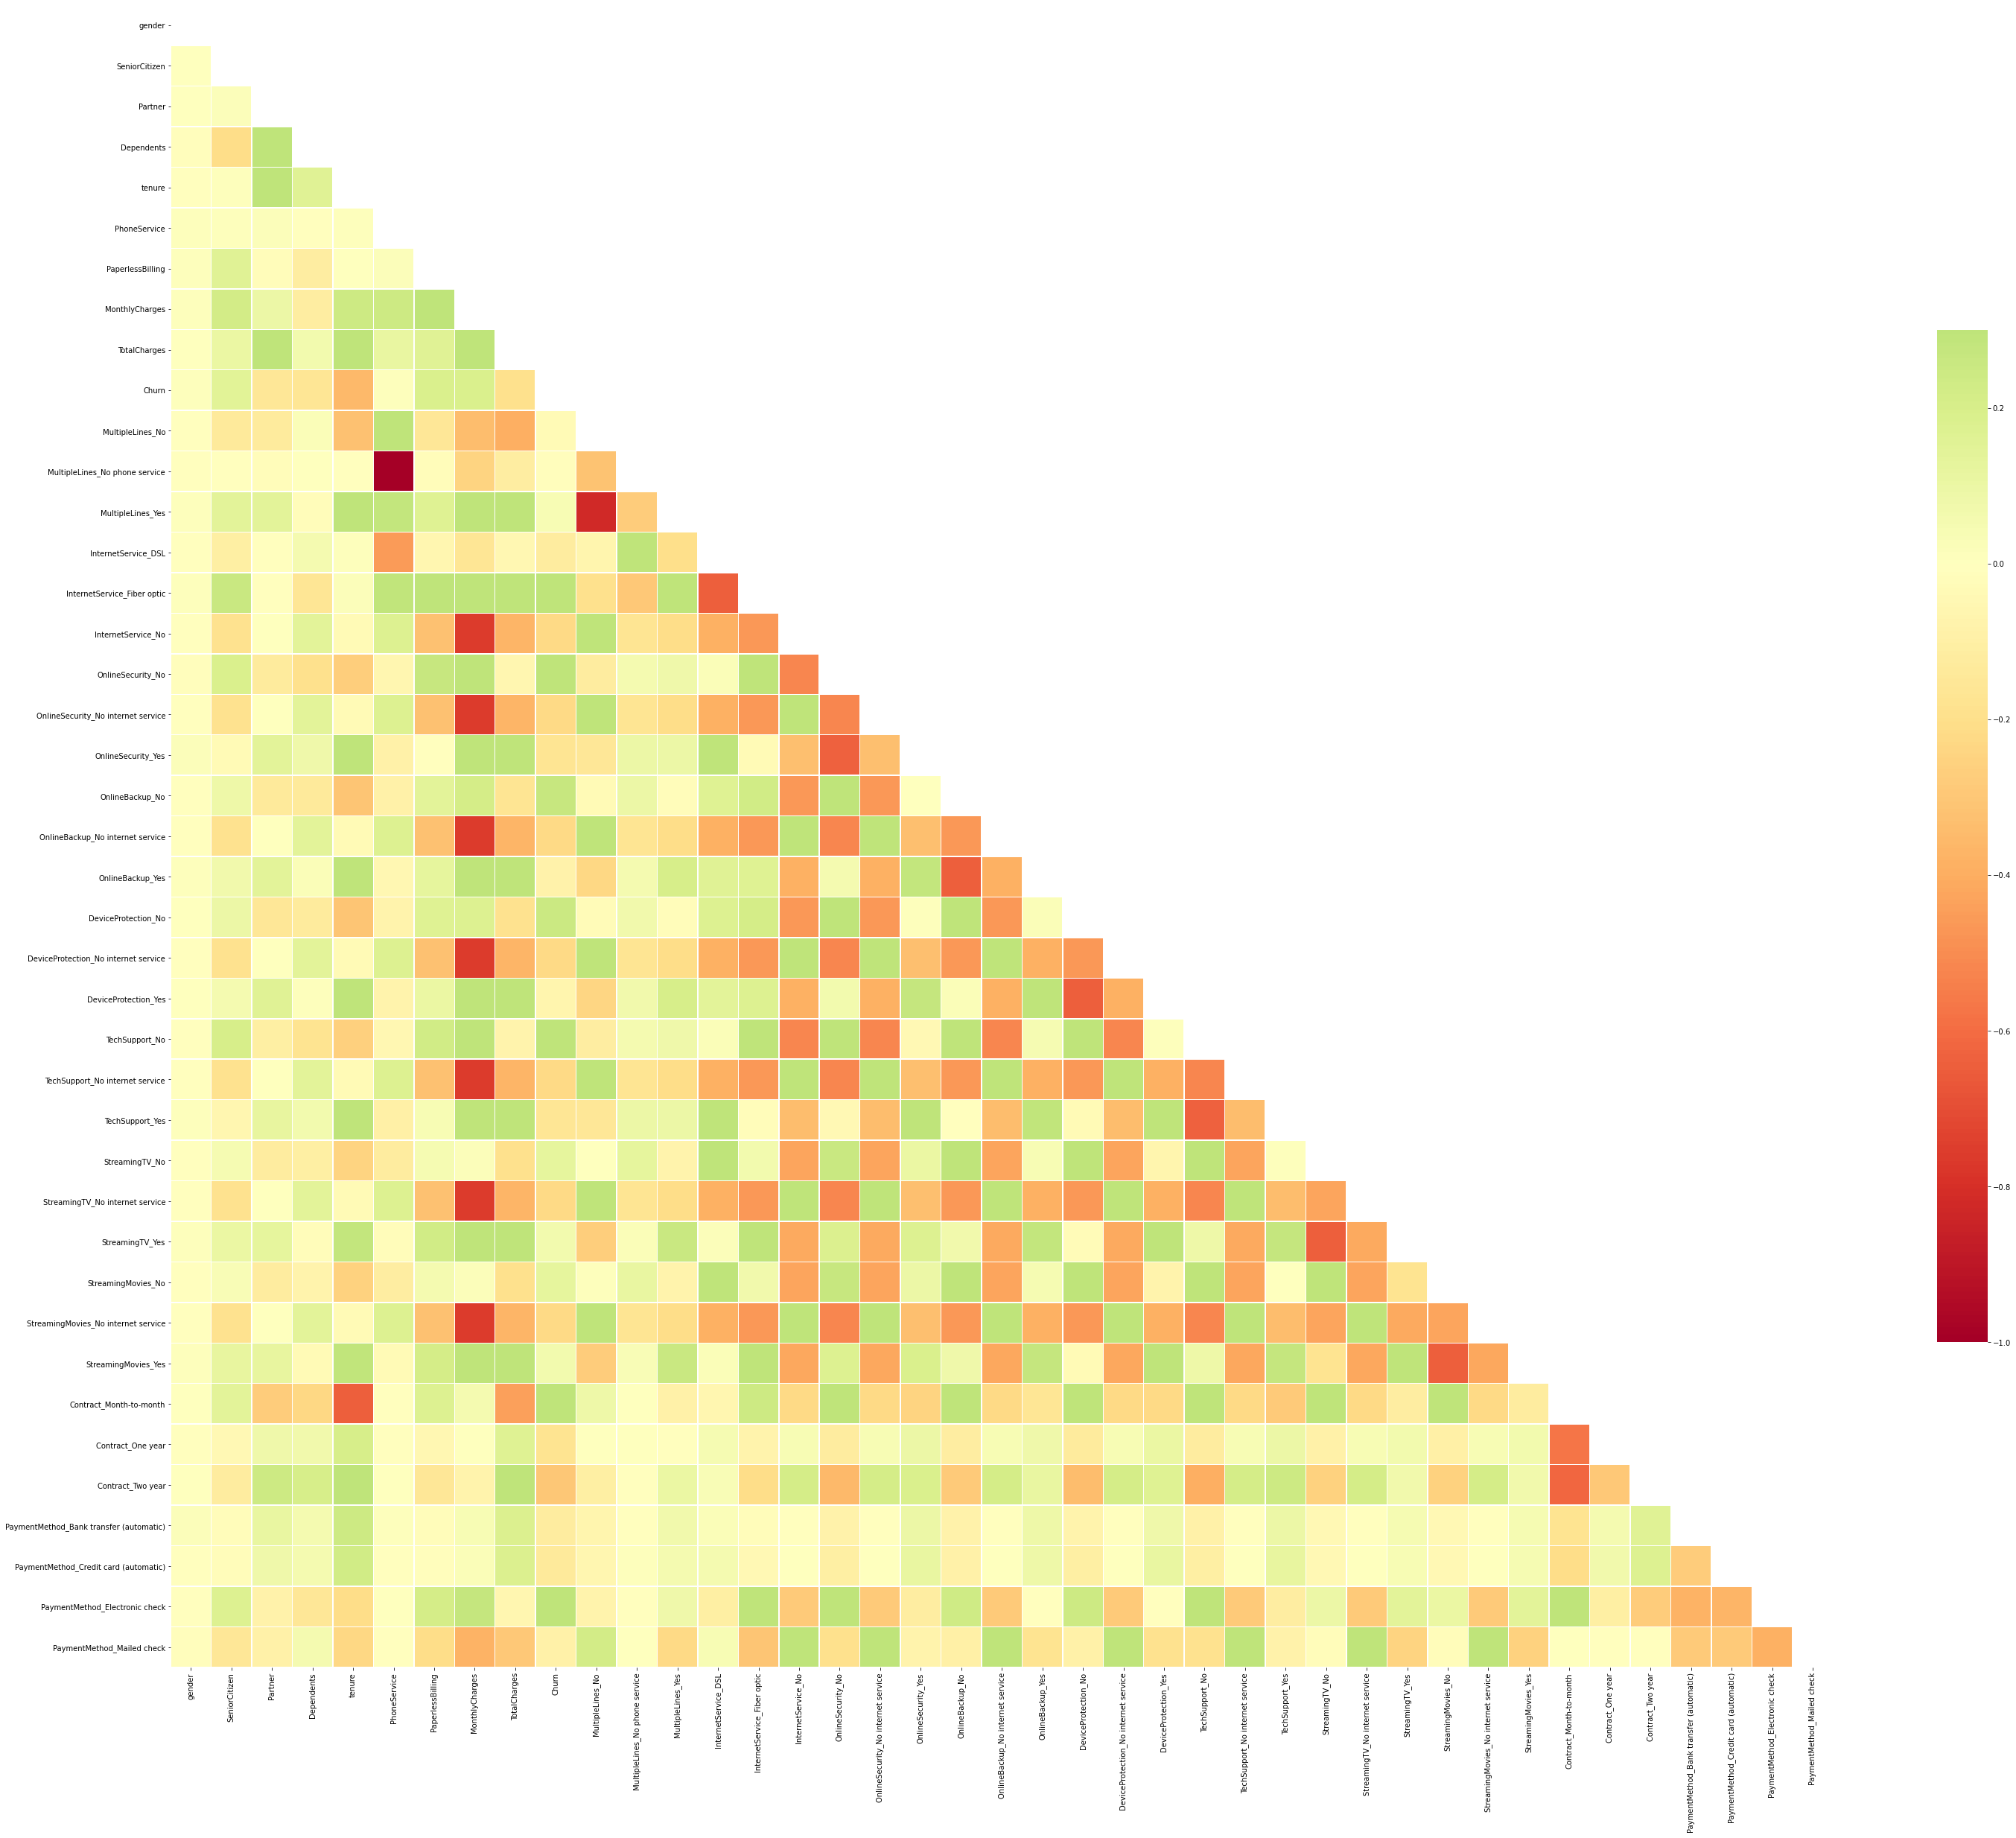

In [27]:
import numpy as np
mask = np.triu(np.ones_like(corrmat, dtype=np.bool))
plt.figure(figsize=(50,50))
g = sns.heatmap(corrmat,annot=False,cmap="RdYlGn", mask=mask, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Your Turn! explore a bit the dataset by generating few graphs based on what we've seen.

# Imbalanced Dataset

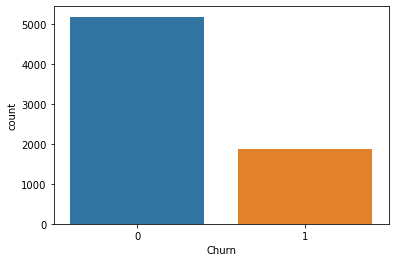

In [28]:
sns.countplot(x='Churn', data=data_df)
plt.show()

Class imbalance is a surprisingly common problem in machine learning (specifically in classification), occurring in datasets with a disproportionate ratio of observations in each class.</br>

That is, the # of samples per class is not equally distributed.</br>

The ML model may not work well for the infrequent classes, as there are not enough samples to learn patterns from, would be hard for the classifier to identify / match those patterns </br>

Apart from changing performance metrics from accuracy to precision, recall, and/or f1 score, other ways to address class imbalance are basically related to balancing either the the dataset or the way ML alg learn from the dataset:</br>


<img src='img/Screen Shot 2021-09-16 at 2.10.05 pm.png' width=800 align='left'>

</br>
We'll later use the XGBoost algorithm to build our model. XGBoost has similar mechanism (scale_pos_weight hyperparameter) to handle imbalanced datasets.
</br>

# Handling Missing Data

<img src='img/Screen Shot 2021-09-16 at 2.14.05 pm.png' width=800 align='left'>

In [29]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            6992 non-null   float64
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


isna() return True/False for each row if value NaN. The below filter the dataframe on 

In [30]:
data_df[data_df['tenure'].isna()].head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
90,4767-HZZHQ,0,0,1,1,NaN,1,No,Fiber optic,No,Yes,Yes,No,No,No,Month-to-month,0,Bank transfer (automatic),82.05,2570.20,0
123,6497-TILVL,1,0,1,1,NaN,1,No,DSL,Yes,No,No,No,No,No,Month-to-month,0,Mailed check,50.70,350.35,0
205,7674-YTAFD,1,0,0,0,NaN,1,No,Fiber optic,No,Yes,No,Yes,No,No,One year,1,Bank transfer (automatic),79.95,2684.85,0
343,9639-BUJXT,0,0,0,0,NaN,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0,Mailed check,20.50,1328.15,0
443,2937-FTHUR,1,0,0,1,NaN,1,Yes,DSL,Yes,No,No,No,No,Yes,Month-to-month,0,Electronic check,64.80,1166.70,0


Simply replacing NaN values with the mean tenure

In [31]:
data_df['tenure'] = data_df['tenure'].fillna(data_df['tenure'].mean())

Look also at: sklearn.impute</br>
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute</br>

SimpleImputer - does substitution with simple strategies: mean, median, most_frequent, constant.</br>
others: IterativeImputer, KNNImputer</br>

# Feature Scaling/Normalisation - (will be covered in more details during the Thursday Tabular ML session)

<img src='img/Screen Shot 2021-09-16 at 4.51.33 pm.png' width=800 align='left'>

We won't need it for our XGBoost example but here is the code snippet if you ever need it.

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features_df = scaler.fit_transform(data_df[["tenure", "MonthlyCharges", "TotalCharges"]])
scaled_features_df[0]

array([0.01388889, 0.11542289, 0.0005027 ])

# Dealing with Outliers
Outliers are extreme values that deviate from other observations on data , they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an outlier is an observation that diverges from an overall pattern on a sample. Careful not to mistake outliers with true data.</br>
for "Univariate" outliers, we can draw graph, histogram to identify those visually and drop them. using percentile is another method</br>
for "Multivariate" ones, it's much harder.</br>

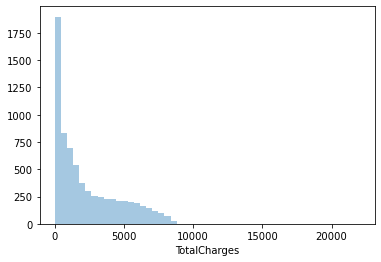

In [33]:
sns.distplot(data_df['TotalCharges'], bins=50, kde=False)
plt.show()

In [34]:
top_percentile = data_df['TotalCharges'].quantile(.99)
number_in_to_percentile = data_df[data_df['TotalCharges'] >= top_percentile].shape[0]
print(f'Number of observations in the 99th percentile:{number_in_to_percentile}')

Number of observations in the 99th percentile:71


### Z-score
Z-score is a common method to flag if a value is an outlier.</br>
Z-Score is essentially how many standard deviations away is my actual value from the mean value.</br>
(standard deviation being a measure of how dispersed the data is in relation to the mean).

We just create a new column with the z-score for each TotalCharges value

In [35]:
data_df['TotalCharges_zscore'] = (data_df['TotalCharges'] - data_df['TotalCharges'].mean())/data_df['TotalCharges'].std(ddof=0)

We filter the dataframe to keep the observations which are deviating from the mean value by 3 times the standard deviation.

In [36]:
data_df[abs(data_df['TotalCharges_zscore']) > 3]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_zscore
45,3714-NTNFO,1,0,0,0,49.0,1,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,1,Electronic check,84.50,20000.0,0,7.702118
2000,7020-OZKXZ,1,1,0,0,9.0,1,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,0,Credit card (automatic),75.50,22000.0,0,8.571994
3000,7613-LLQFO,0,0,0,0,12.0,1,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,1,Electronic check,84.45,21000.0,1,8.137056


In that case we simply delete those outliers

In [37]:
data_df = data_df.drop([45,2000,3000], axis=0)

Dropping the Z-score column too as we don't need it anymore

In [38]:
data_df = data_df.drop('TotalCharges_zscore', axis=1)

# Feature Engineering

Your ML model is as good as your data!!</br>

Feature engineering is the process of using domain knowledge to extract features (characteristics, properties, attributes) from raw data.

<img src='img/Screen Shot 2021-09-16 at 4.57.52 pm.png' width=800 align='left'>

### Feature selection
Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.</br>
Indeed, the performance of some models can degrade when including input variables that are not relevant to the target variable.

Do you remember our correlation matrix? Let's use it again to identify the feature-feature linear dependency and if one is very high that will mean that we can probably drop on of them as they will be redundant to our model.

In [39]:
threshold = 0.99
for rowIndex, row in corrmat.iterrows(): #iterate over rows
    for columnIndex, value in row.items():
        if rowIndex != columnIndex and value > threshold:
            print(f"{rowIndex}  -  {columnIndex}  -  {value}")

InternetService_No  -  OnlineSecurity_No internet service  -  1.0
InternetService_No  -  OnlineBackup_No internet service  -  1.0
InternetService_No  -  DeviceProtection_No internet service  -  1.0
InternetService_No  -  TechSupport_No internet service  -  1.0
InternetService_No  -  StreamingTV_No internet service  -  1.0
InternetService_No  -  StreamingMovies_No internet service  -  1.0
OnlineSecurity_No internet service  -  InternetService_No  -  1.0
OnlineSecurity_No internet service  -  OnlineBackup_No internet service  -  1.0
OnlineSecurity_No internet service  -  DeviceProtection_No internet service  -  1.0
OnlineSecurity_No internet service  -  TechSupport_No internet service  -  1.0
OnlineSecurity_No internet service  -  StreamingTV_No internet service  -  1.0
OnlineSecurity_No internet service  -  StreamingMovies_No internet service  -  1.0
OnlineBackup_No internet service  -  InternetService_No  -  1.0
OnlineBackup_No internet service  -  OnlineSecurity_No internet service  -

We can see that we have 5 strongly correlated features that are directly connected with the InternetService_No

### Feature extraction
e.g. date -> week day, month, year, season.

We don't have dates in the dataset but the customerID has 2 parts that could potentially have a meaning and might be worth extracting. Let's check!</br>

In [40]:
data_df['customerID'].head(2)

0    7590-VHVEG
1    5575-GNVDE
Name: customerID, dtype: object

we create 2 new columns with each parts of the ID

In [41]:
data_df['customerID-part1'] = data_df['customerID'].apply(lambda x: x.split('-')[0])
data_df['customerID-part2'] = data_df['customerID'].apply(lambda x: x.split('-')[1])

We check the cardinality of each feature

In [42]:
data_df[['customerID-part1', 'customerID-part2']].apply(pd.Series.nunique)

customerID-part1    5082
customerID-part2    7037
dtype: int64

It was worth checking but the high cardinality doesn't suggest it will help the algorithm differentiate 2 records. so we'll ignore that and get rid of the customerID.

In [43]:
data_df = data_df.drop(['customerID', 'customerID-part1', 'customerID-part2'], axis=1)

### Feature building/construction
eg: Binning of age. helps with making some models more robust and less prone to overfitting but you loose some info -> tradeoff.</br>

What can a human interprete from looking at the data that an algorithm wouldn't be able to see?

In [44]:
data_df['InternetService'].value_counts()

Fiber optic    3093
DSL            2421
No             1526
Name: InternetService, dtype: int64

We, humans, know that Fiber is around 15 times faster than DSL (6 vs ~90Mbps) but the algorithm won't be able to infer that from that column.</br>
Let's assign a number to those categories that represents the speed on a scale (0 for No, 10 for DSL, 150 for Fiber).</br>

In [45]:
data_df['InternetSpeed'] = data_df['InternetService'].apply(lambda x: 0 if x == 'No' else 10 if x == 'DSL' else 150)

# Encoding Categorical Features

In [46]:
encoded_data_df = one_hot_encoding(data_df)

(7040, 42)


In [47]:
cols_to_drop = ['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'OnlineBackup_No internet service', 
               'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']
encoded_data_df = encoded_data_df.drop(cols_to_drop, axis=1)

In [48]:
encoded_data_df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetSpeed,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1.0,0,1,29.85,29.85,0,10,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0
1,0,0,0,0,34.0,1,0,56.95,1889.50,0,10,1,0,0,1,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1
2,0,0,0,0,2.0,1,1,53.85,108.15,1,10,1,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1
3,0,0,0,0,45.0,0,0,42.30,1840.75,0,10,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,0,0
4,1,0,0,0,2.0,1,1,70.70,151.65,1,150,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0


# Splitting Datasets into Training/Validation/Test

<img src='img/Screen Shot 2021-09-18 at 11.45.26 am.png' width=800 align='left'>

we use a sklearn function for the split and do not forget shuffling your data before splitting to make sure your observations are evenly distributed across train and test.

In [49]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(encoded_data_df, test_size=0.2, shuffle=True)

In [50]:
print(train_df.shape)
print(test_df.shape)

(5632, 36)
(1408, 36)


We now separate our features from the target/label in preparation for training

In [51]:
train_y = train_df['Churn'].copy()
train_x = train_df.drop('Churn', axis=1)

test_y = test_df['Churn'].copy()
test_x = test_df.drop('Churn', axis=1)

# Decision trees & XGBoost - (This will be covered in details during the Thursday Tabular ML session)

<img src='img/Screen Shot 2021-09-19 at 5.54.23 pm.png' width=800 align='left'>

# Training your model with XGBoost
XGBoost documentation:</br>
https://xgboost.readthedocs.io/en/latest/python/python_api.html

In [52]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


</br>
The default objective for XGBoost is 'binary:logistic' which is for binary classification.</br>
Note that you should use 'multi:softprob' when solving a multiclass problem.

In [53]:
import xgboost as xgb

#scale_pos_weight is our way to put more weight on positive observations to help with unbalanced datasets. We basicall tell the algorithm to focus more on the observations that are positive.
#sum(negative instances) / sum(positive instances)
scale_pos_weight = encoded_data_df['Churn'].value_counts()[0]/encoded_data_df['Churn'].value_counts()[1]

eval_set = [(test_x, test_y)]
xgbClassifier = xgb.XGBClassifier(objective="binary:logistic", 
                                  random_state=33, 
                                  n_estimators=50, 
                                  max_depth=4, 
                                  learning_rate=0.3, 
                                  min_child_weight=2, 
                                  scale_pos_weight=scale_pos_weight)
fit_model = xgbClassifier.fit(train_x, train_y, eval_set=eval_set, eval_metric="aucpr", verbose=True, early_stopping_rounds=10)

[0]	validation_0-aucpr:0.64182
[1]	validation_0-aucpr:0.65422
[2]	validation_0-aucpr:0.65781
[3]	validation_0-aucpr:0.65553
[4]	validation_0-aucpr:0.65667
[5]	validation_0-aucpr:0.65383
[6]	validation_0-aucpr:0.66594
[7]	validation_0-aucpr:0.67215
[8]	validation_0-aucpr:0.67252
[9]	validation_0-aucpr:0.67358
[10]	validation_0-aucpr:0.67356
[11]	validation_0-aucpr:0.67622
[12]	validation_0-aucpr:0.67747
[13]	validation_0-aucpr:0.67932
[14]	validation_0-aucpr:0.67944
[15]	validation_0-aucpr:0.67801
[16]	validation_0-aucpr:0.67498
[17]	validation_0-aucpr:0.67454
[18]	validation_0-aucpr:0.67815
[19]	validation_0-aucpr:0.67827
[20]	validation_0-aucpr:0.67851
[21]	validation_0-aucpr:0.67635
[22]	validation_0-aucpr:0.67444
[23]	validation_0-aucpr:0.67333
[24]	validation_0-aucpr:0.67268


We generate predictions for the train dataset to see how it fitted the training data

In [54]:
pred_train_y = xgbClassifier.predict(train_x)

We generate predictions for the test dataset

In [55]:
pred_test_y = xgbClassifier.predict(test_x)

# Model Evaluation

You can use plot_important to understand which features are especially important.</br>
By default, this method calculate "importance" based on the ”weight”. The weight is the number of times a feature appears in a tree.

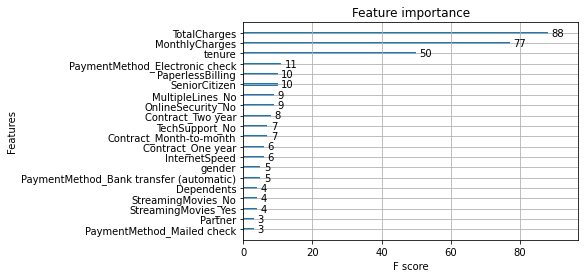

In [56]:
xgb.plot_importance(fit_model,max_num_features=20)
plt.rcParams["figure.figsize"] = (5,10)
plt.show()

In [57]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


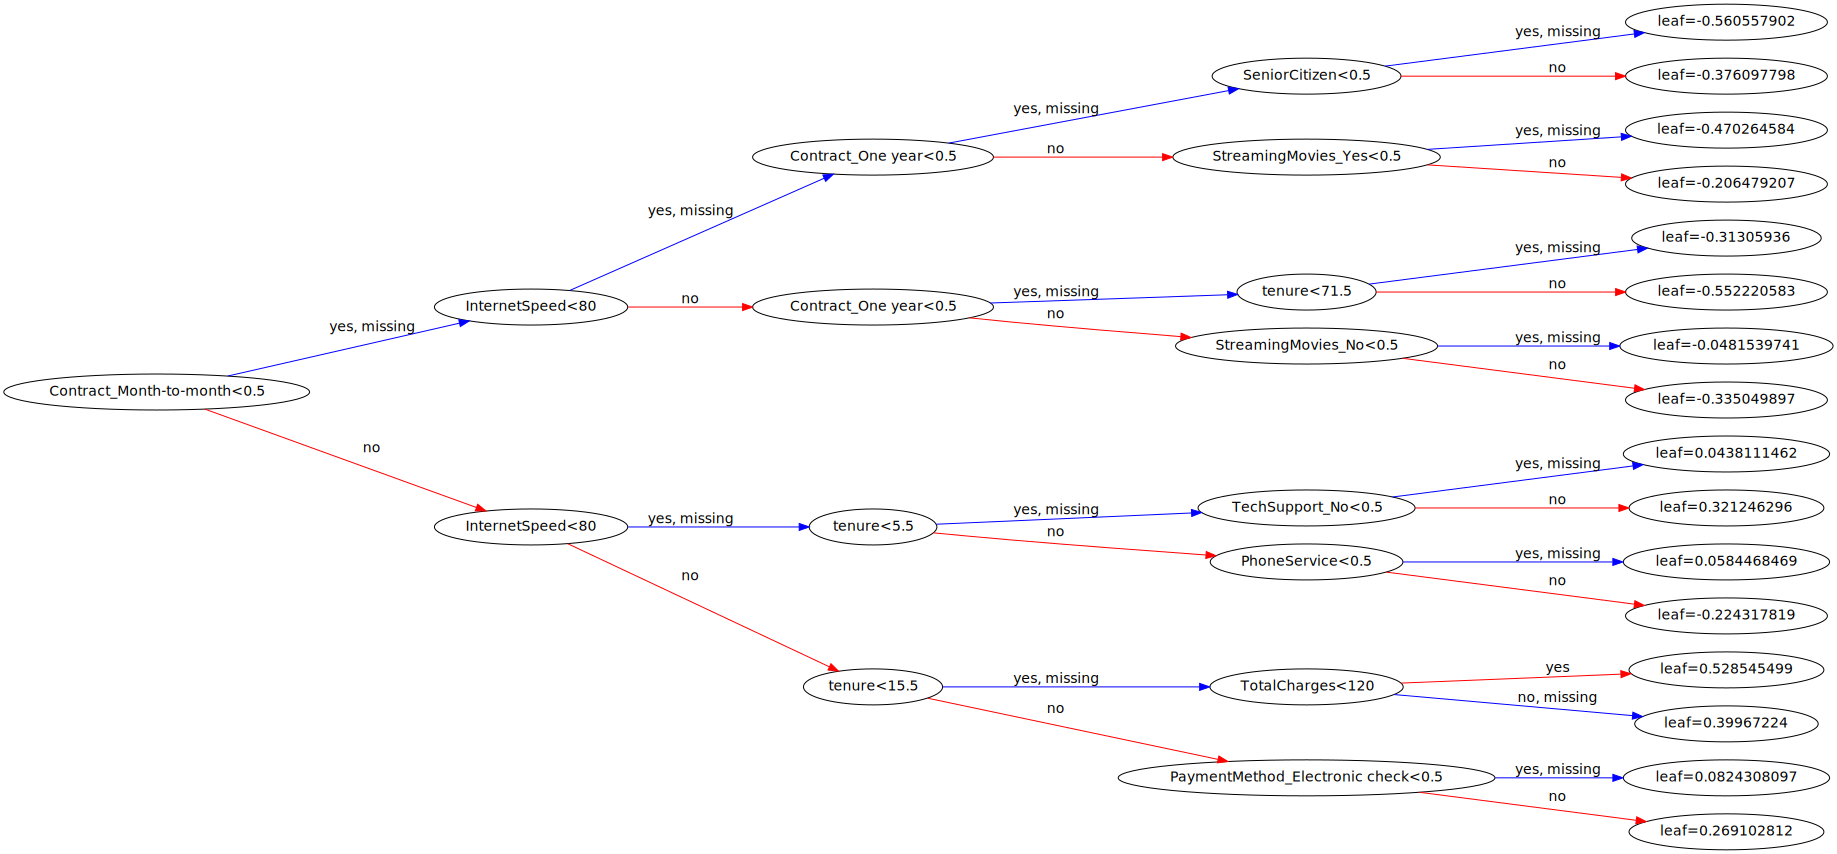

In [58]:
from xgboost import plot_tree
#plot_tree(fit_model, num_trees=1, rankdir='LR')
xgb.to_graphviz(fit_model, num_trees=0, rankdir='LR')

Note that the final probability prediction is obtained by taking sum of leaf values (raw scores) in all the trees and then transforming it between 0 and 1 using a sigmoid function. The leaf value (raw score) can be negative, the value 0 actually represents probability being 1/2.

### Confusion matrix

<img src='img/Screen Shot 2021-09-18 at 12.23.15 pm.png' width=800 align='left'>

<img src='img/Screen Shot 2021-09-19 at 6.02.52 pm.png' width=800 align='left'>

<img src='img/Screen Shot 2021-09-19 at 6.03.14 pm.png' width=800 align='left'>

<img src='img/Screen Shot 2021-09-19 at 6.03.21 pm.png' width=800 align='left'>

<img src='img/Screen Shot 2021-09-19 at 6.03.27 pm.png' width=800 align='left'>

<img src='img/Screen Shot 2021-09-19 at 6.08.02 pm.png' width=800 align='left'>

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [60]:
def print_confusion_matrix(test_y, pred_y):
    tn, fp, fn, tp = confusion_matrix(test_y, pred_y).ravel()
    print(f'{tp} | {fn}')
    print(f'_________')
    print(f'{fp} | {tn}')
    
def print_main_eval_metrics(test_y, pred_y):
    accuracy = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
    roc_auc = roc_auc_score(test_y, pred_y)
    print(f' accuracy:{accuracy}, \n precision:{precision} \n recall:{recall} \n f1:{f1} \n roc_auc:{roc_auc}')

Confusion matrix for the test dataset

In [61]:
print_confusion_matrix(test_y, pred_test_y)

299 | 76
_________
285 | 748


Main metrics for the test dataset

In [62]:
print_main_eval_metrics(test_y, pred_test_y)

 accuracy:0.7436079545454546, 
 precision:0.511986301369863 
 recall:0.7973333333333333 
 f1:0.6235662148070907 
 roc_auc:0.7607189415940626


Main metrics for the train dataset - good but not overfitted

In [63]:
print_main_eval_metrics(train_y, pred_train_y)

 accuracy:0.77734375, 
 precision:0.5534197586052749 
 recall:0.8292029470864032 
 f1:0.6638069705093834 
 roc_auc:0.7939201495518993


</br>
<b>TIPS - When to use F1, Accuracy, ROC AUC, PR AUC? </b></br>

https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc</br>


Accuracy – balanced dataset, when every class is equally important to you</br>

Precision vs Recall - Maximizing precision will minimize the number of false positives, whereas maximizing the recall will minimize the number of false negatives.</br>

For customer churn: more interested in recall than precision. not predicting that a customer will Churn is a big miss but predicting that a customer might churn while they do not will just trigger specific retention campaigns that might be unnecessary.</br>

F1 – every binary classification problem where you care more about the Positive class.</br>

ROC AUC. – DON’T USE when imbalanced dataset. When you care equally about positive and negative. When you care about ranking predictions.</br>
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

PR AUC – when heavily imbalanced dataset. When you care more about positive than negative.</br>


<img src='img/Screen Shot 2021-09-18 at 11.45.34 am.png' width=800 align='left'>

In [64]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
xgbClassifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='aucpr')

scores = cross_val_score(xgbClassifier, train_x, train_y, cv=15, scoring = "average_precision")
#sklearn.metrics.SCORERS.keys()

In [65]:
print(f'average precision across all rounds: {scores.mean()}')

average precision across all rounds: 0.624517554279668


# Underfitting/Overfitting

<img src='img/Screen Shot 2021-09-19 at 11.59.58 am.png' width=800 align='left'>

<img src='img/Screen Shot 2021-09-19 at 12.00.05 pm.png' width=800 align='left'>

<img src='img/Screen Shot 2021-09-19 at 12.00.18 pm.png' width=800 align='left'>

Let's generate an overfitted model!

In [66]:
xgbClassifier_overfit = xgb.XGBClassifier(objective="binary:logistic", random_state=42, max_depth=20, reg_lambda=0, n_estimators=400)
xgbClassifier_overfit.fit(train_x, train_y, eval_metric="aucpr")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

We generate predictions on both the train and test set

In [67]:
over_pred_test_y = xgbClassifier_overfit.predict(test_x)
over_pred_train_y = xgbClassifier_overfit.predict(train_x)

Eval metrics on the training dataset. We see a close to perfect accuracy and f1 score

In [68]:
print_main_eval_metrics(train_y, over_pred_train_y)

 accuracy:0.9975142045454546, 
 precision:0.9953114534494307 
 recall:0.9953114534494307 
 f1:0.9953114534494307 
 roc_auc:0.9968101118418935


In [69]:
print_main_eval_metrics(test_y, over_pred_test_y)

 accuracy:0.7642045454545454, 
 precision:0.5626822157434402 
 recall:0.5146666666666667 
 f1:0.5376044568245126 
 roc_auc:0.684729267505647


# Quick explanation of Regularisation

Regularisation is a way to keep our model's parameter/weights "in check" and not too large. It helps preventing overfitting.</br>
L2 regression is the most known technique.</br>
For tree based methods, it means not having too many "splits" by defining a minimum gain or other methods.
For other types of algorithms, like in linear regression, L2 regression is an additional penalty that is added to the quality metrics (eg: RSS) that forces the algorithm to keep the weights relatively small, and hence avoid 

# Hyperparameters tuning - More details on that on Thursday ML Tabular session

<img src='img/Screen Shot 2021-09-19 at 5.37.35 pm.png' width=800 align='left'>

In [70]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
from random import randint

params = {'max_depth':[3,4,5,6,7],
          'n_estimators':[20, 30, 40, 50],
         'reg_lambda':[0.75, 1, 1.25],
         'min_child_weight':[1,2]}

eval_set = [(test_x, test_y)]

xgbClassifier_HPO = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='aucpr', scale_pos_weight=scale_pos_weight)
search = RandomizedSearchCV(xgbClassifier_HPO, param_distributions=params, random_state=3, n_iter=50,  cv=5, verbose=1, n_jobs=2, return_train_score=True)

search.fit(train_x, train_y, eval_set=eval_set, eval_metric="aucpr", early_stopping_rounds=10)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[0]	validation_0-aucpr:0.64182
[1]	validation_0-aucpr:0.65422
[2]	validation_0-aucpr:0.65782
[3]	validation_0-aucpr:0.65504
[4]	validation_0-aucpr:0.65670
[5]	validation_0-aucpr:0.65382
[6]	validation_0-aucpr:0.66603
[7]	validation_0-aucpr:0.67243
[8]	validation_0-aucpr:0.67035
[9]	validation_0-aucpr:0.67441
[10]	validation_0-aucpr:0.67666
[11]	validation_0-aucpr:0.67843
[12]	validation_0-aucpr:0.67758
[13]	validation_0-aucpr:0.67697
[14]	validation_0-aucpr:0.67557
[15]	validation_0-aucpr:0.67666
[16]	validation_0-aucpr:0.67646
[17]	validation_0-aucpr:0.67526
[18]	validation_0-aucpr:0.67546
[19]	validation_0-aucpr:0.67311


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='aucpr', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=No...
                                           random_state=42, reg_alpha=None,
                                           reg_lambda=None,
                                           sc

In [71]:
print(f"best_params:{search.best_params_}")
print(f"best_score:{search.best_score_}")

best_params:{'reg_lambda': 0.75, 'n_estimators': 20, 'min_child_weight': 2, 'max_depth': 4}
best_score:0.754973120609739


# CONCLUSION

XGBoost is the most popular algorithm for tabular classification problems. Other well known approaches: Random Forest (Decision tree with baggin), Logistic regression.

hyperparameter tuning.

More details on Decision Trees, boosting vs bagging approaches and KNN (K Nearest Neighbour) on Thursday during the ML Tabular session.

# Your Turn! Play a bit with different parameters to see if you can improve the metrics